<a href="https://colab.research.google.com/github/qing-dai/language-project/blob/main/speaker_information_prominence_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Summer Project

This project aims to analyze speaker-specific information prominence within an utterance, with a hypothesis suggesting that this prominence is highest at the beginning of an utterance compared to its middle or end.

The datasets utilized for this study were retrieved from Common Voice, and the hypothesis was tested across three languages: Mandarin, Cantonese, and English.

In [ ]:
pip install praat-parselmouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 18.8 MB/s eta 0:00:00


In [ ]:
pip install noisereduce

In [ ]:
pip install pydub

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).



### **Data Cleaning**
* Exclusion of noisy files and those with a silence proportion exceeding 40%.
* Retention of files with a minimum duration of 6 seconds to ensure adequate length for recognition and understanding.







In [ ]:
import parselmouth
import os
from pydub import AudioSegment, silence
import noisereduce as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import librosa
import io
from scipy.interpolate import interp1d
import concurrent.futures

In [ ]:
data_dir_CN = "/content/drive/MyDrive/2023summerProject/CN-clips"

In [ ]:
data_dir_EN = "/content/drive/MyDrive/2023summerProject/EN-clips"

In [ ]:
data_dir_HK = "/content/drive/MyDrive/2023summerProject/HK-clips"

In [ ]:
def proportion_of_silence(audio, silence_thresh=-40, min_silence_len=500):

    """Calculate the proportion of silence in an audio segment.
    Silence threshold: -40dB.
    minimum length of a silence period: 500ms"""

    silent_periods = silence.detect_silence(audio, silence_thresh=silence_thresh, min_silence_len=min_silence_len)
    total_silence_duration = sum([end - start for start, end in silent_periods])
    return total_silence_duration / len(audio)

In [ ]:
def audio_variance(audio_segment):
  """Compute the variance of an audio segment"""
  samples = np.array(audio_segment.get_array_of_samples())
  return np.var(samples)

In [ ]:
import os
from pydub import AudioSegment

def process_single_file(args):
    '''
    Processes an audio file, truncating it to 6 seconds if it's longer, and excluding it if shorter.
    The file is only returned if:
    1. Its audio variance is above a set threshold (1e5), indicating quality.
    2. Its proportion of silence is less than 40%.
    3. Its length is exactly 6 seconds after processing.
    '''
    f, data_dir = args
    file_path = os.path.join(data_dir, f)

    # Ensure the "temp" directory exists
    temp_dir = os.path.join(data_dir, "temp")
    os.makedirs(temp_dir, exist_ok=True)  # Add exist_ok=True to prevent FileExistsError
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    if os.path.isfile(file_path) and f.lower().endswith('.mp3'):
        audio = AudioSegment.from_mp3(file_path)

        # Check if the file is at least 6 seconds (6000 milliseconds) long
        if len(audio) >= 6000:
            # Truncate to the first 6 seconds (6000 milliseconds)
            audio = audio[:6000]
        else:
            # Exclude files shorter than 6 seconds
            return None

        variance_threshold = 1e5
        # Exclude files with low variance (potentially noisy)
        if audio_variance(audio) < variance_threshold:
            return None

        # Check the proportion of silence
        silence_proportion = proportion_of_silence(audio)
        # Exclude files with a silence proportion greater than 0.4 (40%)
        if silence_proportion > 0.4:
            return None

        # Export the truncated audio to a temporary file and return its path
        temp_file_path = os.path.join(temp_dir, f)
        audio.export(temp_file_path, format='mp3')
        return temp_file_path

    return None


####**Date preprocessing**

for Mandarine, English and Cantonese files to ensure  below conditions.

    1. Its audio variance is above a set threshold (1e5), indicating quality.
    2. Its proportion of silence is less than 40%.
    3. Its length is exactly 6 seconds

##### Mandarine files preprocessing

In [ ]:
# Use all available CPU cores
pool = Pool(cpu_count())
# Process files in parallel
args_CN = [(f, data_dir_CN) for f in os.listdir(data_dir_CN)]
results_CN = pool.map(process_single_file, args_CN)
# Filter out None values from results
filtered_files_CN = [f for f in results_CN if f is not None]
print(f"Number of CN files before processing: {len(args_CN)}, after processing: {len(filtered_files_CN)}")

Number of CN files before processing: 1738, after processing: 374


In [ ]:
## Verify all files are 6 seconds long

def check_file_duration(file_path, expected_length_ms=6000):
    audio = AudioSegment.from_file(file_path)
    return len(audio) == expected_length_ms

# Use all available CPU cores
pool = Pool(cpu_count())

# Create full file paths
file_paths_CN = [os.path.join(data_dir_CN, f) for f in filtered_files_CN[:100]]

# Check the durations in parallel
durations_correct = pool.map(check_file_duration, file_paths_CN)

# Close the pool
pool.close()
pool.join()

# Verify that all durations are correct
all_durations_correct = all(durations_correct)
print(f"All files are 6 seconds long: {all_durations_correct}")


All files are 6 seconds long: True


##### English files preprocessing

In [ ]:
pool = Pool(cpu_count())
args_EN = [(f, data_dir_EN) for f in os.listdir(data_dir_EN)]
results_EN = pool.map(process_single_file, args_EN)
filtered_files_EN = [f for f in results_EN if f is not None]
print(f"Number of EN files before processing: {len(args_EN)}, after processing: {len(filtered_files_EN)}")

Number of EN files before processing: 1230, after processing: 366


In [ ]:
# Verify all truncated English files are 6s long
# Create full file paths
file_paths_EN = [os.path.join(data_dir_EN, f) for f in filtered_files_EN[:100]]

# Check the durations in parallel
durations_correct = pool.map(check_file_duration, file_paths_EN)

# Close the pool
pool.close()
pool.join()

# Verify that all durations are correct
all_durations_correct = all(durations_correct)
print(f"All files are 6 seconds long: {all_durations_correct}")

All files are 6 seconds long: True


##### Cantonese files preprocessing

In [ ]:
pool = Pool(cpu_count())
args_HK = [(f, data_dir_HK) for f in os.listdir(data_dir_HK)]
results_HK = pool.map(process_single_file, args_HK)
filtered_files_HK = [f for f in results_HK if f is not None]
print(f"Number of HK files before processing: {len(args_HK)}, after processing: {len(filtered_files_HK)}")

Number of HK files before processing: 1520, after processing: 84


In [ ]:
# Verify all truncated Cantonese files are 6s long
# Create full file paths
file_paths_HK = [os.path.join(data_dir_HK, f) for f in filtered_files_HK]

# Check the durations in parallel
durations_correct = pool.map(check_file_duration, file_paths_HK)

# Close the pool
pool.close()
pool.join()

# Verify that all durations are correct
all_durations_correct = all(durations_correct)
print(f"All files are 6 seconds long: {all_durations_correct}")

All files are 6 seconds long: True


# Extract F0 and formants

Based on files with same length of 6s from the beginning

#### Class AudioFeatureProcessor
to extract F0 and formants (F1, F2, F3)

In [ ]:
import numpy as np
import librosa
from parselmouth import Sound, praat

class AudioFeatureProcessor:
    '''
    An AudioFeatureProcessor is to extract F0 and formants
    '''
    def __init__(self, files, data_dir):
        self.files = files
        self.data_dir = data_dir

    def load_audio(self, file_path):
        y, sr = librosa.load(file_path, sr=None)
        return y, sr
ava
    def extract_f0(self, y, sr):
        pitch, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        pitch = np.nan_to_num(pitch, nan=np.mean(pitch[~np.isnan(pitch)]))
        return pitch

    def extract_formants(self, file_path):
      # limit to F1, F2, F3
        snd = Sound(file_path)
        formants = praat.call(snd, "To Formant (burg)", 0.0025, 3, 5500, 0.02, 50)

        # Calculate formants every 10 ms instead of at each point for speed up
        step_size = 0.01  # 10 ms
        time_points = np.arange(0, snd.duration, step_size)
        formant_data = np.array([[formants.get_value_at_time(i, t) for i in range(1, 4)] for t in time_points])
        return formant_data


    # def extract_mfccs(self, y, sr):
    #     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #     return mfccs

    def process_file_for_f0(self, file):
        file_path = os.path.join(self.data_dir, file)
        y, sr = self.load_audio(file_path)
        f0 = self.extract_f0(y, sr)
        return f0

    def process_file_for_formants(self, file):
        file_path = os.path.join(self.data_dir, file)
        formants = self.extract_formants(file_path)
        return formants


    def average_f0(self):
        with Pool(cpu_count()) as pool:
            all_f0 = pool.map(self.process_file_for_f0, self.files)

        # Find the length of the longest F0 array
        max_length = max(len(f0) for f0 in all_f0)

        # Pad shorter F0 arrays with NaNs to match the longest array
        padded_f0 = [np.pad(f0, (0, max_length - len(f0)), 'constant', constant_values=np.nan) for f0 in all_f0]

        avg_f0 = np.nanmean(np.vstack(padded_f0), axis=0)
        return avg_f0


    def average_formants(self):
        with Pool(cpu_count()) as pool:
            all_formants = pool.map(self.process_file_for_formants, self.files)

        # Find the maximum length of the formant arrays
        max_length = max(formant.shape[0] for formant in all_formants)

        # Pad shorter formant arrays
        padded_formants = [np.pad(formant, ((0, max_length - formant.shape[0]), (0, 0)), 'constant', constant_values=np.nan) for formant in all_formants]

        # Calculate the average formants, ignoring NaNs
        avg_formants = np.nanmean(np.dstack(padded_formants), axis=2)
        return avg_formants

#### Mandarine files F0 and formants

In [ ]:
processor_CN = AudioFeatureProcessor(filtered_files_CN, data_dir_CN)

In [ ]:
# Mandarine F0
avg_f0_CN = processor_CN.average_f0()

##### Mandarine F0 plot

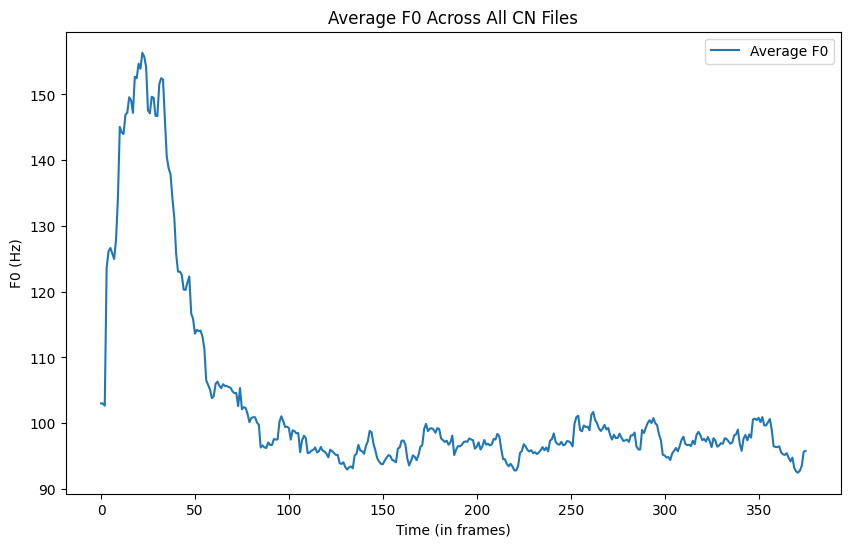

In [ ]:
# Plotting CN averaged F0
plt.figure(figsize=(10, 6))
plt.plot(avg_f0_CN, label='Average F0')
plt.xlabel('Time (in frames)')
plt.ylabel('F0 (Hz)')
plt.title('Average F0 Across All CN Files')
plt.legend()
plt.show()

In [ ]:
# Mandarine formants
avg_formants_CN = processor_CN.average_formants()

<ipython-input-23-efb24fb8ef57>:74: RuntimeWarning: Mean of empty slice
  avg_formants = np.nanmean(np.dstack(padded_formants), axis=2)


##### Mandarine formants plot

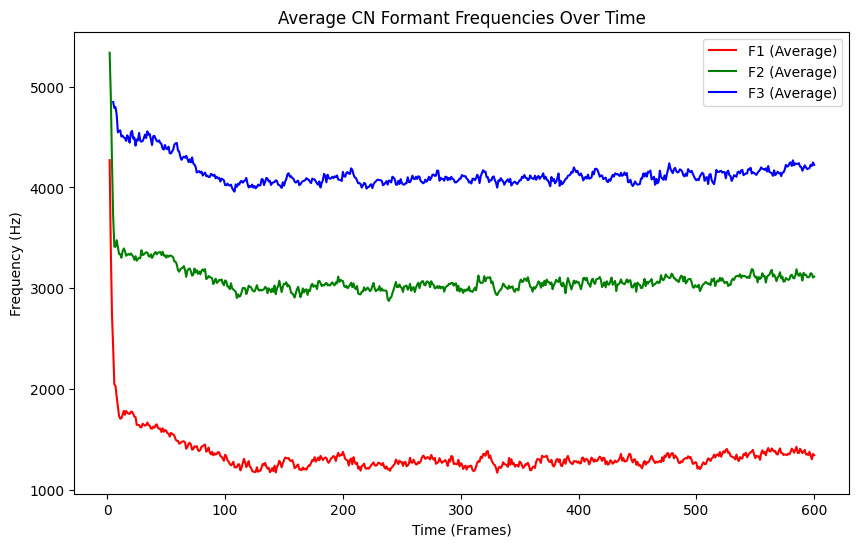

In [ ]:
# Plotting formants
# Assuming avg_formants_CN is the averaged formant data you obtained
# It should be a 2D array with shape [num_frames, 3] (for F1, F2, F3)

# Plotting
plt.figure(figsize=(10, 6))
time_frames = np.arange(avg_formants_CN.shape[0])

# Plot each formant
plt.plot(time_frames, avg_formants_CN[:, 0], label='F1 (Average)', color='red')
plt.plot(time_frames, avg_formants_CN[:, 1], label='F2 (Average)', color='green')
plt.plot(time_frames, avg_formants_CN[:, 2], label='F3 (Average)', color='blue')

plt.xlabel('Time (Frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Average CN Formant Frequencies Over Time')
plt.legend()
plt.show()


#### English files F0 and formants

In [ ]:
# EN F0
processor_EN = AudioFeatureProcessor(filtered_files_EN, data_dir_EN)
avg_f0_EN = processor_EN.average_f0()

##### English F0 plot

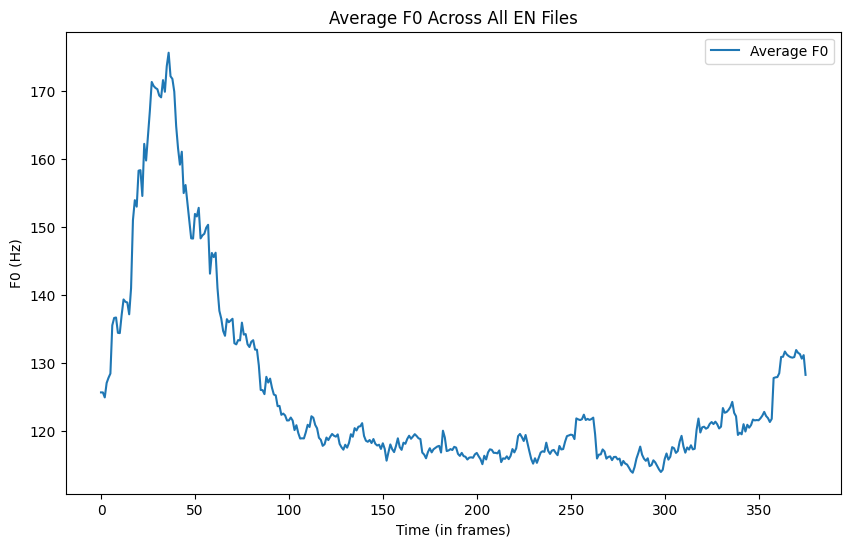

In [ ]:
# Plotting EN averaged F0
plt.figure(figsize=(10, 6))
plt.plot(avg_f0_EN, label='Average F0')
plt.xlabel('Time (in frames)')
plt.ylabel('F0 (Hz)')
plt.title('Average F0 Across All EN Files')
plt.legend()
plt.show()

In [ ]:
# EN formants
avg_formants_EN = processor_EN.average_formants()

<ipython-input-23-efb24fb8ef57>:74: RuntimeWarning: Mean of empty slice
  avg_formants = np.nanmean(np.dstack(padded_formants), axis=2)


##### English formants plot

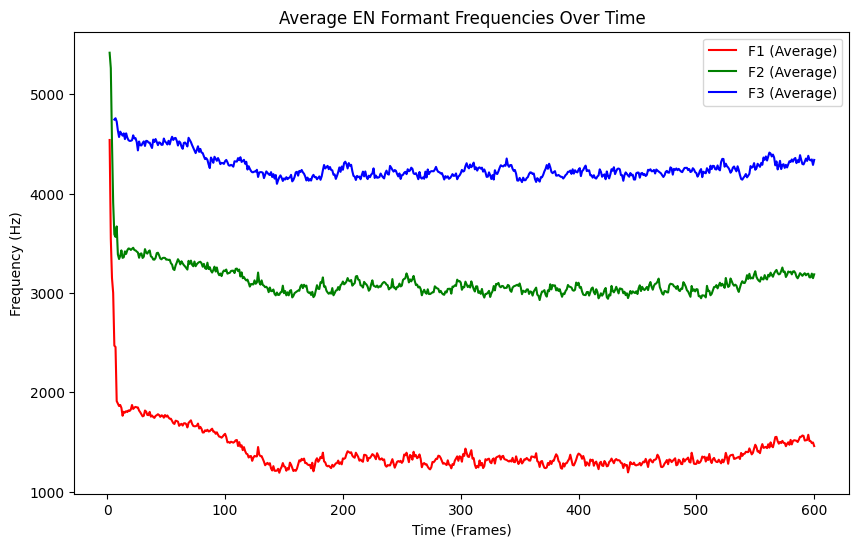

In [ ]:
# Plot EN formants
plt.figure(figsize=(10, 6))
time_frames = np.arange(avg_formants_EN.shape[0])

# Plot each formant
plt.plot(time_frames, avg_formants_EN[:, 0], label='F1 (Average)', color='red')
plt.plot(time_frames, avg_formants_EN[:, 1], label='F2 (Average)', color='green')
plt.plot(time_frames, avg_formants_EN[:, 2], label='F3 (Average)', color='blue')

plt.xlabel('Time (Frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Average EN Formant Frequencies Over Time')
plt.legend()
plt.show()


#### Cantonese Files F0 and formants

In [ ]:
# HK F0
processor_HK = AudioFeatureProcessor(filtered_files_HK, data_dir_HK)
avg_f0_HK = processor_HK.average_f0()

##### Cantonese F0 plot

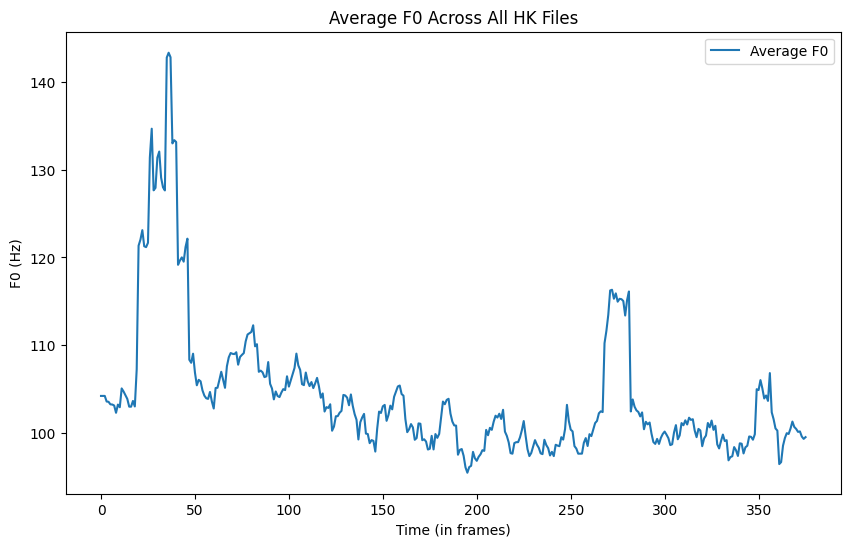

In [ ]:
# Plotting HK averaged F0
plt.figure(figsize=(10, 6))
plt.plot(avg_f0_HK, label='Average F0')
plt.xlabel('Time (in frames)')
plt.ylabel('F0 (Hz)')
plt.title('Average F0 Across All HK Files')
plt.legend()
plt.show()

In [ ]:
# HK formants
avg_formants_HK = processor_HK.average_formants()

<ipython-input-23-efb24fb8ef57>:74: RuntimeWarning: Mean of empty slice
  avg_formants = np.nanmean(np.dstack(padded_formants), axis=2)


##### Cantonese formants plot

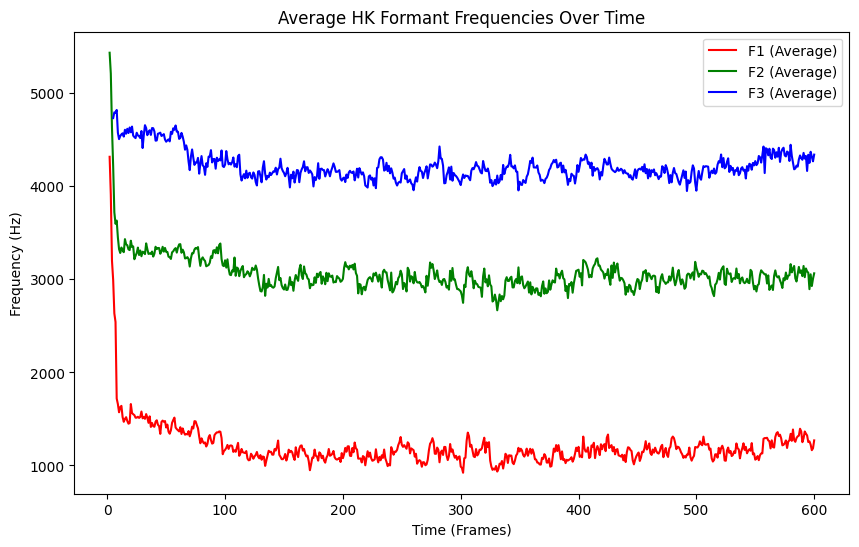

In [ ]:
# plot HK formants
plt.figure(figsize=(10, 6))
time_frames = np.arange(avg_formants_HK.shape[0])

# Plot each formant
plt.plot(time_frames, avg_formants_HK[:, 0], label='F1 (Average)', color='red')
plt.plot(time_frames, avg_formants_HK[:, 1], label='F2 (Average)', color='green')
plt.plot(time_frames, avg_formants_HK[:, 2], label='F3 (Average)', color='blue')

plt.xlabel('Time (Frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Average HK Formant Frequencies Over Time')
plt.legend()
plt.show()

# **Data Processing with interpolation**

Below snippet keeps the initial trail with length not truncated to 6s, but the length is at least 6s. So to enable comparability across different length of files, we adopt interpolating normalization.

Due to the expensive computation process, only mandarine files are tested.

**Linear Interpolation**

 Linear interpolation was employed to standardize the number of pitch values across all files, enabling direct comparability. This technique involves estimating missing values for files with fewer pitch values than a predefined standard and summarizing those with more.
Different interpolation anchor points were experimented with, including:
* 100 points
* 500 points







### **Set number of interpolation points as 100**

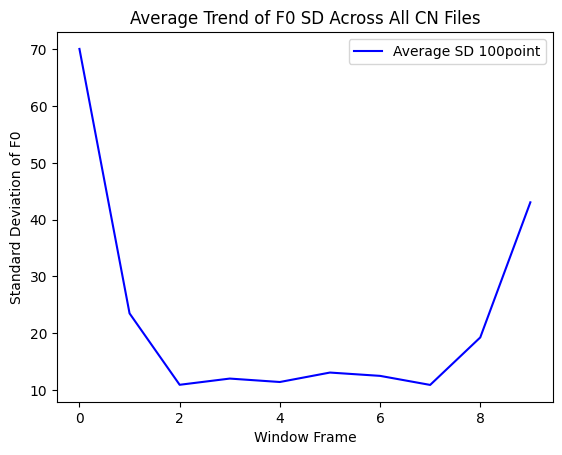

In [ ]:
def load_audio(file_path):
    audio = AudioSegment.from_mp3(file_path)
    audio = audio.set_channels(1)  # Convert to mono
    buffer = io.BytesIO()
    audio.export(buffer, format="wav")
    buffer.seek(0)
    y, sr = librosa.load(buffer, sr=None)
    return y, sr

# Number of interpolation points
num_points = 100

# List to store SD values for all files
all_sd_values_CN = []

for file in filtered_files_CN:
    file_path = os.path.join(data_dir_CN, file)

    y, sr = load_audio(file_path)
    pitch, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    # Handle NaN values in the pitch contour
    if np.isnan(pitch).any():
        nan_indices = np.isnan(pitch)
        non_nan_indices = ~nan_indices
        interp_func = interp1d(np.where(non_nan_indices)[0], pitch[non_nan_indices], kind='linear', fill_value='extrapolate')
        pitch[nan_indices] = interp_func(np.where(nan_indices)[0])


    # Interpolate the pitch values
    interpolated_pitch = np.interp(np.linspace(0, len(pitch), num_points), np.arange(len(pitch)), pitch)

    # Compute SD for each window frame
    sd_values = [np.std(interpolated_pitch[i:i+10]) for i in range(0, num_points, 10)]
    all_sd_values_CN.append(sd_values)

# Compute the average SD values across all files
average_sd_values_CN = np.mean(all_sd_values_CN, axis=0)

# Plotting
plt.plot(average_sd_values_CN, color='blue', label='Average SD 100point')
plt.xlabel('Window Frame')
plt.ylabel('Standard Deviation of F0')
plt.title('Average Trend of F0 SD Across All CN Files')
plt.legend()
plt.show()




### **Set number of interpolation points as 500**

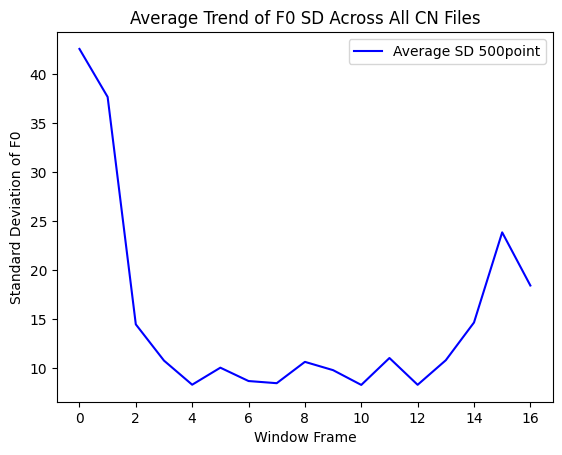

In [ ]:
# Increase the number of interpolation points for finer resolution
num_points = 500

# Decrease the window size for more SD values
window_size = 30

all_sd_values_CN = []

for file in filtered_files_CN:
    file_path = os.path.join(data_dir_CN, file)

    y, sr = load_audio(file_path)
    pitch, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

        # Handle NaN values in the pitch contour
    if np.isnan(pitch).any():
        nan_indices = np.isnan(pitch)
        non_nan_indices = ~nan_indices
        interp_func = interp1d(np.where(non_nan_indices)[0], pitch[non_nan_indices], kind='linear', fill_value='extrapolate')
        pitch[nan_indices] = interp_func(np.where(nan_indices)[0])

    # Interpolate the pitch values
    interpolated_pitch = np.interp(np.linspace(0, len(pitch), num_points), np.arange(len(pitch)), pitch)

    # Compute SD for each window frame
    sd_values = [np.std(interpolated_pitch[i:i+window_size]) for i in range(0, num_points, window_size)]
    all_sd_values_CN.append(sd_values)

# Compute the average SD values across all files
average_sd_values = np.mean(all_sd_values_CN, axis=0)

# Plotting
plt.plot(average_sd_values, color='blue', label='Average SD 500point')
plt.xlabel('Window Frame')
plt.ylabel('Standard Deviation of F0')
plt.title('Average Trend of F0 SD Across All CN Files')
plt.legend()
plt.show()

